In [46]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [49]:
%%sql --module logspreview1
SELECT response_text FROM [shwetaproject-001:eMee_SMCC.sample100] where not response_text in ("null", "NULL")

In [50]:
import datalab.bigquery as bq
# Create a query using the SQL module defined above.
q = bq.Query(logspreview1)
# Run the query, with caching turned off (for sample purposes only), so we're sure to be
# able to retrieve metadata, such as bytes processed from the resulting query job.
results = q.results()
list1=list(results)
#for k in list1:
  #print(k['response_text'])

In [51]:
import string
punctuation = list(string.punctuation)
stopwords = nltk.corpus.stopwords.words('english') + punctuation + ['rt', 'via', 'https', 'sonysix', 'sabtv', 'sonypix', 'bbcearth']

In [52]:
print(stopwords[:10])

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [53]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [54]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_https]+)', # other words
    r'(?:[\w_]+)', # other words
    r'https',
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def tokenize_and_stem(text, lowercase=False):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    #tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = tokenize(text)
    filtered_tokens = []
    tokens1 = [token.lower() if tokens_re.search(token.lower()) else token.lower() for token in tokens]
    tokens = [term for term in tokens1 if term not in stopwords and len(term)>1]
    #print(tokens)
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
      if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text, lowercase=False):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    #tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = tokenize(text)
    filtered_tokens = []
    tokens1 = [token.lower() if emoticon_re.search(token.lower()) else token.lower() for token in tokens]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    tokens = [term for term in tokens1 if term not in stopwords and len(term)>1]
    for token in tokens:
      if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in list1:
    allwords_stemmed = tokenize_and_stem(i['response_text']) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i['response_text'])
    totalvocab_tokenized.extend(allwords_tokenized)

In [56]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 982 items in vocab_frame


In [57]:
print(vocab_frame.head())
print()
print
print
print

         words
fill      fill
form      form
member  member
sub        sub
famili  family



<function print>

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,min_df=0.2, stop_words='english',use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,5))
arr=[]
for k in list1:
  tmp=k['response_text']
  #print(tmp)
  tmp=tokenize_only(tmp)
  s=""
  for i in tmp:
    s=s+" "+i
  s=re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s)
  #print(s)
  arr.append(s)
tfidf_matrix=tfidf_vectorizer.fit_transform(arr) #fit the vectorizer to synopses
print(tfidf_matrix.shape)

(100, 4)


In [59]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

[u'dildekedekhoonsab', u'generat', u'love', u'watch']


In [60]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [61]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
print(clusters)

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 51.6 ms
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 0, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 1, 2, 1, 1, 1, 2, 2, 3, 4, 3, 2, 0, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 3, 4, 1, 4, 0, 0, 0, 2, 3, 3, 1, 3, 1, 1, 0, 3, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 3, 4, 1, 4, 0, 1, 3, 4, 1, 1, 1, 1, 4, 2, 1, 3, 3, 1, 0]


In [62]:
films = { 'tweet': arr, 'cluster': clusters}

frame = pd.DataFrame(films, index = [clusters] , columns = ['tweet', 'cluster'])

In [63]:
data1=frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

In [65]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
#print(order_centroids)
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :5]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d tweets:" % i, end='')
    print()
    for title in frame.ix[i]['tweet'].values.tolist():
       print(title)
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: love, generations, dildekedekhoonsab, watch,

Cluster 0 tweets:
 hitler_uncle show going unusual show love story boundries dildekedekhoonsab
 loving interaction star cast media bhopal dildekedekhoonsab co lkvchmz wx
 dildekedekhoonsab amazing love story entertainer starting th oct pm co kibbzqbew
 watch generations fall love love age im excited new show dildekedekhoonsab
 show love story three generations gonna aired th hrs dildekedekhoonsab
 story generations fall love love age im excited new show dildekedekhoonsab
 must check crazy love stories generations sounds interesting dildekedekhoonsab
 beautiful love story generations dildekedekhoonsab
 curious watch three generations love story dildekedekhoonsab
 amit_tandon loved excitement show dildekedekhoonsab co mxxn dz6tg
 amit_tandon excited watch amazing unique love story three generations dildekedekhoonsab
 yes truly loved lovely background dildekedekhoonsab
 fun cant get better dildekedekhoo

In [66]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [67]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'sonytv, kushalt2803, https', 
                 1: 'tnaweekendtakeover, sonysix, acting', 
                 2: 'sabtv, dildekedekhoonsab, sabkidiwaliexclusives', 
                 3: ' singing,acting, modelling', 
                 4: 'sonypix, thejurassicquiz, acting'}

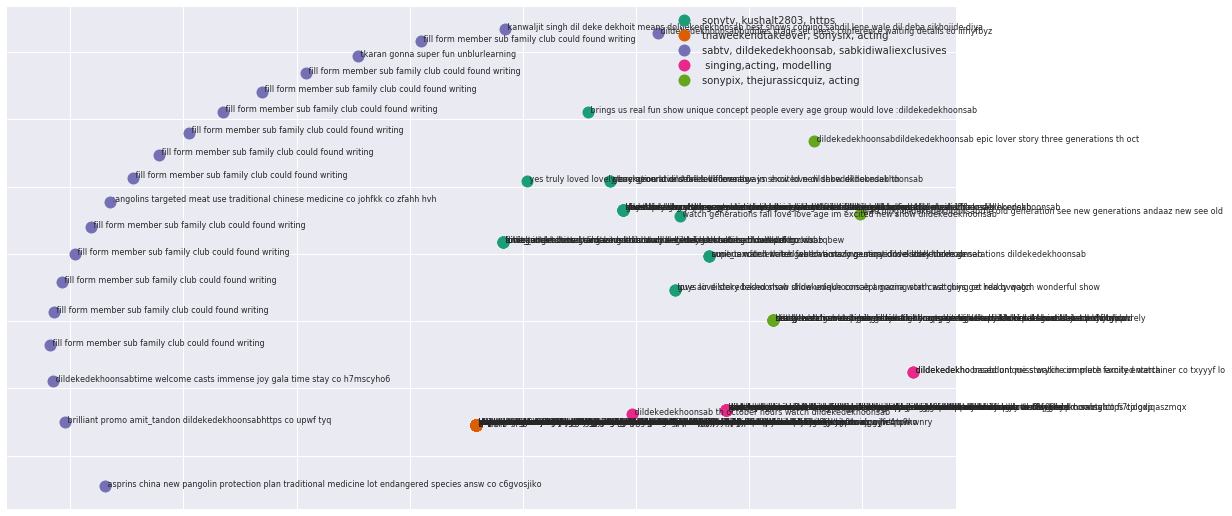

In [68]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=arr)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)